<a href="https://colab.research.google.com/github/sushilyadav9713/names/blob/main/femaleNamesGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [165]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/sushilyadav9713/names/refs/heads/main/FemaleNames.txt

--2025-03-29 14:12:16--  https://raw.githubusercontent.com/sushilyadav9713/names/refs/heads/main/FemaleNames.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155558 (152K) [text/plain]
Saving to: ‘FemaleNames.txt’

FemaleNames.txt     100%[===================>] 151.91K  --.-KB/s    in 0.02s   

2025-03-29 14:12:16 (8.09 MB/s) - ‘FemaleNames.txt’ saved [155558/155558]



In [166]:
words = open('femaleNames.txt', 'r').read().splitlines()
words[:8]

['', 'shivani', 'isha', 'smt shyani devi', 'divya', 'mansi', 'mazida', 'pooja']

In [167]:
len(words)

15312

In [168]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: '\t', 2: ' ', 3: '$', 4: '+', 5: ':', 6: '`', 7: 'a', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'h', 15: 'i', 16: 'j', 17: 'k', 18: 'l', 19: 'm', 20: 'n', 21: 'o', 22: 'p', 23: 'q', 24: 'r', 25: 's', 26: 't', 27: 'u', 28: 'v', 29: 'w', 30: 'x', 31: 'y', 32: 'z', 33: 'ई', 34: 'त', 35: 'ब', 36: 'र', 37: 'ल', 38: 'ा', 39: 'ी', 0: '.'}


In [169]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([112332, 3]) torch.Size([112332])
torch.Size([14130, 3]) torch.Size([14130])
torch.Size([13870, 3]) torch.Size([13870])


In [170]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((40, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 40), generator=g)
b2 = torch.randn(40, generator=g)
parameters = [C, W1, b1, W2, b2]

In [171]:
sum(p.nelement() for p in parameters) # number of parameters in total

14640

In [172]:
for p in parameters:
  p.requires_grad = True

In [173]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [174]:
lri = []
lossi = []
stepi = []

In [181]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.05 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

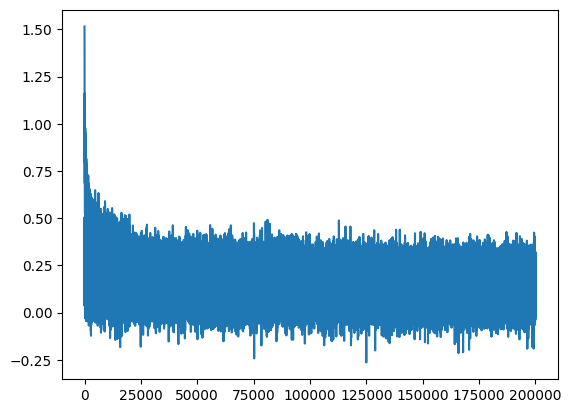

In [182]:
plt.plot(stepi, lossi)

In [183]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.4540, grad_fn=<NllLossBackward0>)

In [184]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.6329, grad_fn=<NllLossBackward0>)

In [185]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.5783, grad_fn=<NllLossBackward0>)

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2312 (\N{DEVANAGARI LETTER II}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  func(

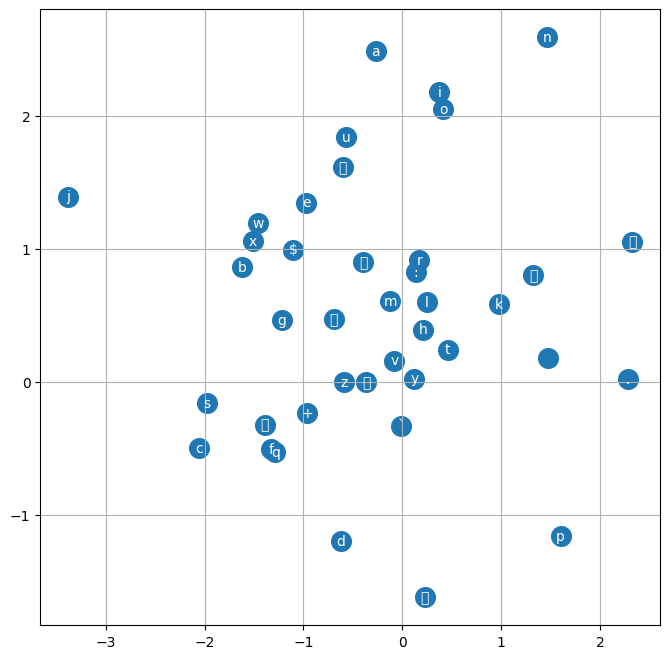

In [186]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [190]:
# sample from the model
g = torch.Generator().manual_seed(214748364)

for _ in range(100000):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

Streaming output truncated to the last 5000 lines.
seju.
farzana.
gun.
prekharunam.
lalti kumar.
smt rinki devi.
ren.
kumari.
anjali devi.
rajinab.
pooja.
babita.
sapna.
babli.
sapna.
indu leelam kumari meenakshi aroji kha parvleelarti.
manita.
meen.
renounam.
santosh  devi.
sumarinki.
gurbahkhasingh.
sha sareelam.
pooja.
pooja.
pooja.
kalpa devi.
pinki kaun parveena.
anjal.
afsahi.
shobi kunwar.
kan bai.
maibra.
mani.
indra.
smt masudekha.
megharti.
rajni.
mina kha.
kaja.
mita do rawar sha kumari charma.
narseema.
durgan.
smt murala.
bebta.
mamari.
radhu.
pooja.
durga devi.
noor.
zari.
chander kosh.
aanni.
kavita.
babli.
pooja.
geety  maharma.
reenakshilakshila.
ti.
santi.
hai.
chanu.
rajni.
kumka.
nika.
sangeetala devi.
nandizeeena devi.
rupa.
man.
amsa naykunty.
pri.
ajma.
leelamanjan.
afsangi bai.
manjacrma.
samijannomari.
priya.
khushna.
manju shilpa ashi  mati bailwa.
neha.
smt unpreeti.
sahuja.
purni.
prita.
shan.
guddiya.
kajal.
urmina divy kumariju.
sarkasta devi.
ramal.
komal